In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import theano.tensor as T

In [3]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}) ,
    (Flatten, [], {'which_sources': 'features'}) )

cifar_train = CIFAR10(("train",), subset=slice(None,40000))
cifar_train_stream = DataStream.default_stream(
    cifar_train, iteration_scheme=ShuffledScheme(cifar_train.num_examples, 100))
                                               
cifar_validation = CIFAR10(("train",), subset=slice(40000, None))
cifar_validation_stream = DataStream.default_stream(
    cifar_validation, iteration_scheme=SequentialScheme(cifar_validation.num_examples, 250))

cifar_test = CIFAR10(("test",))
cifar_test_stream = DataStream.default_stream(
    cifar_test, iteration_scheme=SequentialScheme(cifar_test.num_examples, 250))

In [4]:
from modules.Network import Network
from modules.layers.SoftMaxLayer import SoftMaxLayer
from modules.layers.AffineLayer import AffineLayer
from modules.layers.ConvolutionalPoolLayer import ConvolutionalPoolLayer
from modules.initializers.Normal import Normal

In [5]:
ReLU = lambda x: T.maximum(0.0, x)

net = Network([ConvolutionalPoolLayer(image_shape=(3,32,32), filter_shape=(16,3,5,5), pool_shape=(4,4)),
               AffineLayer(16*7*7, 64, activation=ReLU),
               SoftMaxLayer(64, 10, weights_initializer=Normal(std=0.08)) ])

train_cost, valid_errors, train_errors = net.train(cifar_train_stream, cifar_validation_stream, 8e-3, 0.95, 1e-3)

At batch #100, batch cost: 2.554179
At batch #200, batch cost: 2.313009
At batch #300, batch cost: 2.274417
At batch #400, batch cost: 1.933619
After epoch 1: validation error: 52.630000%
Currently going to do 3 epochs
At batch #500, batch cost: 1.914269
At batch #600, batch cost: 1.938113
At batch #700, batch cost: 1.809996
At batch #800, batch cost: 1.871158
After epoch 2: validation error: 44.750000%
Currently going to do 4 epochs
Setting the best obtained parameters...


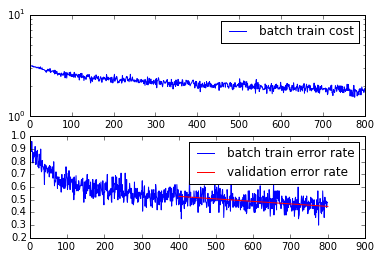

In [6]:
subplot(2,1,1)
semilogy(train_cost[:,0], train_cost[:,1], label='batch train cost')
legend()

subplot(2,1,2)
plot(train_errors[:,0], train_errors[:,1], label='batch train error rate')
plot(valid_errors[:,0], valid_errors[:,1], label='validation error rate', color='r')
legend()

In [7]:
net.compute_error_rate(cifar_test_stream)

0.4437